NOMBRES: Diego Alberto

APELLIDOS: Leiva Pérez

CARNE: 21752

FECHA: 04/09/2025

## Librerias

In [1]:
import re
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

## Utilidades para Texto

In [2]:
def normalize_text(text: str) -> str:
    """
    Convierte a minúsculas, elimina puntuación y caracteres especiales,
    y normaliza espacios en blanco.
    Args:
        text (str): Texto a normalizar.
    Returns:
        str: Texto normalizado.
    """
    text = text.lower()
    # Conserva letras (incluye tildes/ñ), dígitos y espacios.
    text = re.sub(r"[^a-záéíóúüñ0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    """
    Tokeniza el texto normalizado en palabras.
    Args:
        text (str): Texto a tokenizar.
    Returns:
        list: Lista de tokens (palabras).
    """
    return normalize_text(text).split()

def build_vocab(tokenized_docs, min_freq: int = 1):
    """
    Construye el vocabulario a partir de documentos tokenizados.
    Args:
        tokenized_docs (list): Lista de documentos tokenizados.
        min_freq (int): Frecuencia mínima para incluir una palabra en el vocabulario.
    Returns:
        tuple: (vocabulario, word2idx, idx2word, counts)
    """
    counts = Counter([t for doc in tokenized_docs for t in doc])
    vocab = [w for w, c in counts.items() if c >= min_freq]
    vocab = sorted(vocab)
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for i, w in enumerate(vocab)}
    return vocab, word2idx, idx2word, counts

def sliding_windows_indices(center, window_size, n):
    """
    Obtiene los índices de las palabras en una ventana deslizante alrededor de una palabra central.
    Args:
        center (int): Índice de la palabra central.
        window_size (int): Tamaño de la ventana (número de palabras a cada lado).
        n (int): Longitud total de la secuencia.
    Returns:
        list: Lista de índices en la ventana deslizante.
    """
    start = max(0, center - window_size)
    end = min(n, center + window_size + 1)
    return [i for i in range(start, end) if i != center]

## Ejercicio 1
Cree un corpus a su gusto como el visto en clase, cálcule PPMI, pero aplicando Lapace Smoothing.

In [3]:
corpus_docs = [
    # Familia (relaciones directas)
    "el abuelo camina con la abuela por la plaza y conversan en la casa",
    "el padre conversa con la madre en la cocina y preparan almuerzo",
    "el hermano ayuda a la hermana con la tarea y ordenan la sala",
    "el esposo acompaña a la esposa al mercado y compran verduras",
    "el tio visita al sobrino los domingos y juegan cartas en la sala",
    "la tia visita a la sobrina los sabados y conversan en la casa",
    "el primo estudia con el hijo en la escuela y comparten cuadernos",
    "la prima estudia con la hija en la escuela y comparten pinturas",
    "el abuelo y la abuela preparan cafe; el padre y la madre preparan sopa",
    "el hermano y la hermana escuchan musica y acomodan libros",
    "el esposo saluda a la esposa en la puerta y el padre abraza a la madre",

    # Actividades (relaciones persona-actividad)
    "la abuela hace jardineria en el jardin y la hija aprende pintura en la escuela",
    "el padre aprende mecanica en el taller y el hijo hace skate",
    "el tio sale a pesca en el lago y el primo juega videojuegos en la sala",
    "la tia ensaya danza con musica y la prima toma fotografia en el parque",

    # Refuerzos de relaciones
    "el abuelo habla con la abuela en la sala",
    "el padre habla con la madre en la sala",
    "el hermano conversa con la hermana en la cocina",
    "el esposo conversa con la esposa en la sala",
    "el tio conversa con la tia en la casa",
    "el sobrino conversa con la sobrina en el jardin",
    "el primo conversa con la prima en la escuela",
    "el hijo conversa con la hija en la casa",

    # Espejo directo de relaciones
    "el abuelo abraza a la abuela y el padre abraza a la madre",
    "el hermano ayuda a la hermana y el esposo apoya a la esposa",
    "el tio visita al sobrino y la tia visita a la sobrina",
    "el primo estudia con el hijo y la prima estudia con la hija",

    # Refuerzo ligero para actividades
    "la tia dirige danza en la escuela y la prima estudia fotografia en la escuela",
]


# Preprocesamiento
tokenized_docs = [tokenize(d) for d in corpus_docs] # Lista de listas de tokens
vocab, word2idx, idx2word, counts = build_vocab(tokenized_docs, min_freq=1) # Vocabulario y mapeos

# Estadísticas básicas
print("Docs:", len(tokenized_docs)) # Número de documentos
print("Vocab size:", len(vocab)) # Tamaño del vocabulario 
print("Top-10 más frecuentes:", Counter([t for d in tokenized_docs for t in d]).most_common(10)) # Top-10 palabras más frecuentes

Docs: 28
Vocab size: 81
Top-10 más frecuentes: [('la', 56), ('el', 36), ('en', 23), ('y', 22), ('con', 16), ('a', 11), ('conversa', 7), ('padre', 6), ('sala', 6), ('escuela', 6)]


### Matriz de co-ocurrencias

In [4]:
def build_cooccurrence(tokenized_docs, word2idx, window_size=2):
    """
    Construye la matriz de co-ocurrencias a partir de documentos tokenizados.
    Args:
        tokenized_docs (list): Lista de documentos tokenizados.
        word2idx (dict): Mapeo de palabras a índices.
        window_size (int): Tamaño de la ventana deslizante.
    Returns:
        np.ndarray: Matriz de co-ocurrencias.
    """
    V = len(word2idx)
    M = np.zeros((V, V), dtype=float)
    for doc in tokenized_docs:
        n = len(doc)
        for i, w in enumerate(doc):
            wi = word2idx[w]
            for j in sliding_windows_indices(i, window_size, n):
                cj = word2idx[doc[j]]
                M[wi, cj] += 1.0
    return M

In [5]:
WINDOW = 3 # Tamaño de la ventana deslizante
ALPHA = 1.0 # Parámetro de suavizado para PPMI-Laplace
C = build_cooccurrence(tokenized_docs, word2idx, window_size=WINDOW) # Matriz de co-ocurrencias
cooc_df= pd.DataFrame(C,index=vocab,columns=vocab)
cooc_df
cooc_df.iloc[:15,:15]

,a,abraza,abuela,abuelo,acomodan,acompaña,al,almuerzo,apoya,aprende,ayuda,cafe,camina,cartas,casa
a,0.0,3.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
abraza,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abuela,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
abuelo,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
acomodan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acompaña,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
al,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
almuerzo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
apoya,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aprende,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PPMI con Laplace smoothing

In [6]:
def ppmi_laplace(C, alpha=1.0, eps=1e-12):
    """
    Calcula la matriz PPMI con suavizado de Laplace a partir de la matriz de co-ocurrencias.
    Args:
        C (np.ndarray): Matriz de co-ocurrencias.
        alpha (float): Parámetro de suavizado de Laplace.
        eps (float): Pequeña constante para evitar log(0).
    Returns:
        np.ndarray: Matriz PPMI.
    """
    C_s = C + alpha
    total = float(C_s.sum()) + eps
    Pwc = C_s / total
    Pw = Pwc.sum(axis=1, keepdims=True)
    Pc = Pwc.sum(axis=0, keepdims=True)
    PMI = np.log((Pwc + eps) / (Pw @ Pc + eps))
    return np.maximum(PMI, 0.0)

In [7]:
PPMI = ppmi_laplace(C, alpha=ALPHA)
ppmi_df = pd.DataFrame(PPMI, index=vocab, columns=vocab)
ppmi_df.iloc[:15,:15]

,a,abraza,abuela,abuelo,acomodan,acompaña,al,almuerzo,apoya,aprende,ayuda,cafe,camina,cartas,casa
a,0.000000,0.854631,0.055103,0.171740,0.000000,0.292104,0.151331,0.000000,0.280543,0.000000,0.641057,0.000000,0.000000,0.000000,0.000000
abraza,0.854631,0.000000,0.432980,0.549617,0.000000,0.000000,0.000000,0.000364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
abuela,0.055103,0.432980,0.000000,0.443237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552040,0.563601,0.000000,0.000000
abuelo,0.171740,0.549617,0.443237,0.000000,0.000000,0.000000,0.000000,0.010621,0.000000,0.000000,0.000000,0.000000,0.680238,0.000000,0.000000
acomodan,0.000000,0.000000,0.000000,0.000000,0.130846,0.119150,0.000000,0.142681,0.107589,0.051709,0.062638,0.107589,0.119150,0.107589,0.040898
acompaña,0.292104,0.000000,0.000000,0.000000,0.119150,0.107454,0.000000,0.130985,0.095893,0.040013,0.050942,0.095893,0.107454,0.095893,0.029202
al,0.151331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
almuerzo,0.000000,0.000364,0.000000,0.010621,0.142681,0.130985,0.000000,0.154515,0.119424,0.063543,0.074472,0.119424,0.130985,0.119424,0.052732
apoya,0.280543,0.000000,0.000000,0.000000,0.107589,0.095893,0.000000,0.119424,0.084332,0.028452,0.039381,0.084332,0.095893,0.084332,0.017641
aprende,0.000000,0.000000,0.000000,0.000000,0.051709,0.040013,0.000000,0.063543,0.028452,0.000000,0.000000,0.028452,0.040013,0.028452,0.000000


### Similitud coseno y vecinos

In [8]:
def cosine_similarity_matrix(X):
    """
    Calcula la matriz de similitud coseno entre vectores.
    Args:
        X (np.ndarray): Matriz de vectores (filas).
    Returns:
        np.ndarray: Matriz de similitud coseno.
    """
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    Xn = X / norms
    return Xn @ Xn.T

def top_k_neighbors(word, vocab, simM, k=5):
    """
    Obtiene los k vecinos más similares a una palabra dada usando la matriz de similitud.
    Args:
        word (str): Palabra objetivo.
        vocab (list): Lista de palabras en el vocabulario.
        simM (np.ndarray): Matriz de similitud coseno.
        k (int): Número de vecinos a retornar.
    Returns:
        list: Lista de tuplas (palabra, similitud) de los k vecinos más similares.
    """
    if word not in vocab:
        return []
    i = vocab.index(word)
    row = simM[i].copy()
    row[i] = -np.inf
    idxs = np.argsort(-row)[:k]
    return [(vocab[j], float(row[j])) for j in idxs]

In [9]:
S = cosine_similarity_matrix(PPMI) # Matriz de similitud coseno
sim_df = pd.DataFrame(S, index=vocab, columns=vocab)

targets = ["abuelo", "abuela", "padre", "madre", "hijo", "hija", "tio", "tia", "primo", "prima"]
# Iterar sobre algunas palabras de interés y mostrar sus vecinos más cercanos
for t in targets:
    print(f"\nVecinos de '{t}': ")
    for w,s in top_k_neighbors(t,vocab,S,k=5):
        print(f" {w:>12}\t{s:.3f}")


Vecinos de 'abuelo': 
        padre	0.612
        madre	0.450
       abuela	0.445
     conversa	0.391
            a	0.355

Vecinos de 'abuela': 
        madre	0.497
       abuelo	0.445
        padre	0.388
         cafe	0.356
          por	0.336

Vecinos de 'padre': 
       abuelo	0.612
        madre	0.503
            a	0.394
       abuela	0.388
       abraza	0.385

Vecinos de 'madre': 
        padre	0.503
       abuela	0.497
       abuelo	0.450
     almuerzo	0.392
           el	0.389

Vecinos de 'hijo': 
        primo	0.548
        prima	0.458
         hija	0.430
          con	0.411
     conversa	0.394

Vecinos de 'hija': 
        prima	0.563
           en	0.517
           la	0.461
         hijo	0.430
          con	0.395

Vecinos de 'tio': 
      sobrino	0.466
          los	0.451
       visita	0.425
           al	0.421
     domingos	0.398

Vecinos de 'tia': 
      sobrina	0.383
       dirige	0.366
          tio	0.366
       ensaya	0.320
           al	0.313

Vecinos de 'primo': 
      

### Embeddings con SVD

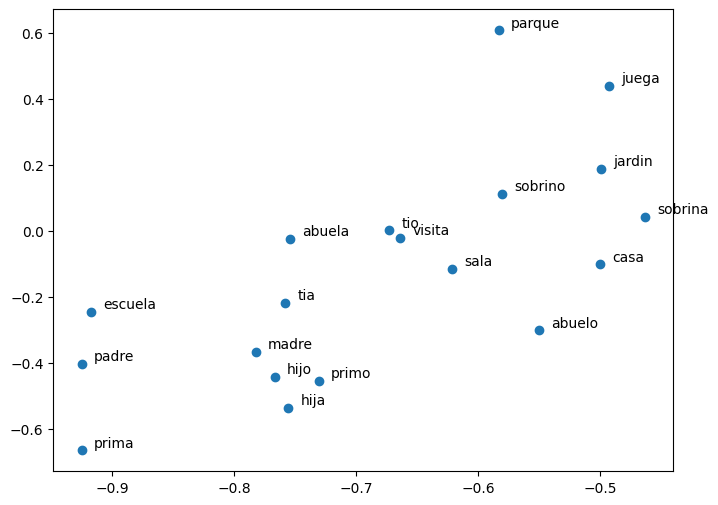

In [10]:
U, s, Vt = np.linalg.svd(PPMI, full_matrices=False)
X2D= U[:,:2]* s[:2]  # Proyección 2D
K = min(50, U.shape[1])   # #dims
E = U[:, :K] * s[:K] # Embeddings

words_to_plot = [
    "abuelo", "abuela", "padre", "madre", "hijo", "hija",
    "tio", "tia", "primo", "prima", "sobrino", "sobrina",
    "niño", "niña", "joven", "adulto", "mayor",
    "juega", "pinta", "practica", "visita",
    "casa", "sala", "jardin", "parque", "escuela"
]

# Filtrar coordenadas y etiquetas para las palabras a graficar
mask = [ w in words_to_plot for w in vocab]
coords = X2D[mask]
labels = [w for w in vocab if w in words_to_plot]

# Graficar
plt.figure(figsize=(8,6))
plt.scatter(coords[:,0],coords[:,1])
for (x,y),lab in zip(coords,labels):
  plt.text(x+0.01,y+0.01,lab)
plt.show()

## Ejercicio 2

Crear 10 analigias validas basadas en su texto, tome en cuenta que es necesario utilizar el codigo visto en clase y ajuste su corpus para poder lograr obtener todas las analogias

In [11]:
Ufull, sfull,Vtfull= np.linalg.svd(PPMI,full_matrices=False)

K=min(50,Ufull.shape[1])
E = Ufull[:,:K] * sfull[:K]

In [12]:
def word_vec(word, vocab=vocab, E=E):
    """
    Obtiene el vector de embedding para una palabra dada.
    Args:
        word (str): Palabra objetivo.
        vocab (list): Lista de palabras en el vocabulario.
        E (np.ndarray): Matriz de embeddings.
    Returns:
        np.ndarray or None: Vector de embedding o None si la palabra no está en el vocabulario.
    """
    if word not in vocab:
        return None
    return E[vocab.index(word)]

def most_similar(vec, E=E, topn=5, exclude_idx=None):
    """
    Encuentra las palabras más similares a un vector dado usando similitud coseno.
    Args:
        vec (np.ndarray): Vector objetivo.
        E (np.ndarray): Matriz de embeddings.
        topn (int): Número de palabras similares a retornar.
        exclude_idx (int or None): Índice a excluir de los resultados (por ejemplo, la palabra misma).
    Returns:
        tuple: (índices de palabras similares, similitudes)
    """
    norms = np.linalg.norm(E, axis=1, keepdims=True) + 1e-12
    En = E / norms
    vn = vec / (np.linalg.norm(vec) + 1e-12)
    sims = En @ vn
    if exclude_idx is not None:
        sims[exclude_idx] = -np.inf
    idxs = np.argsort(-sims)[:topn]
    return idxs, sims[idxs]

def analogy(a, b, c, vocab=vocab, E=E, topn=5):
    """
    Resuelve analogías del tipo "a es a b como c es a ?".
    Args:
        a (str): Primera palabra de la analogía.
        b (str): Segunda palabra de la analogía.
        c (str): Tercera palabra de la analogía.
        vocab (list): Lista de palabras en el vocabulario.
        E (np.ndarray): Matriz de embeddings.
        topn (int): Número de resultados a retornar.
    Returns:
        list: Lista de tuplas (palabra, similitud) de las palabras que completan la analogía.
    """
    va, vb, vc = word_vec(a, vocab, E), word_vec(b, vocab, E), word_vec(c, vocab, E)
    if va is None or vb is None or vc is None:
        return []
    target = vb - va + vc
    idxs, sims = most_similar(target, E=E, topn=topn + 3)
    results = []
    forbids = {vocab.index(w) for w in [a, b, c] if w in vocab}
    for idx, score in zip(idxs, sims):
        if idx not in forbids:
            results.append((vocab[idx], float(score)))
        if len(results) == topn:
            break
    return results

### Analogías

In [13]:
tests = [
    # Género (parejas familiares)
    ("abuelo", "abuela", "padre", "madre"),
    ("padre", "madre", "hijo", "hija"),
    ("tio", "tia", "sobrino", "sobrina"),
    ("primo", "prima", "hermano", "hermana"),
    ("esposo", "esposa", "padre", "madre"),
    ("abuelo", "abuela", "hermano", "hermana"),
    # Actividades (relaciones persona-actividad)
    ("padre", "mecanica", "hijo", "skate"),
    ("abuela", "jardineria", "hija", "pintura"),
    ("tio", "pesca", "primo", "videojuegos"),
    ("tia", "danza", "prima", "fotografia"),
]

rows = []
for a, b, c, expected in tests:
    preds = analogy(a, b, c, topn=5)
    top3 = preds[:3]

    # calcular probs softmax sobre los 3 scores
    scores = [s for _, s in top3]

    # formatear como "palabra:prob"
    top3_fmt = [f"{w}: {p:.2f}" for (w, _), p in zip(top3, scores)]

    # ver si esperado aparece en top3
    rank = next((i for i, (w, _) in enumerate(top3) if w == expected), None) 

    rows.append({
        "analogia": f"{a}:{b} => {c}:?",
        "esperado": expected,
        "top3": " | ".join(top3_fmt),
        "acierto": rank is not None,
        "posicion": (rank + 1 if rank is not None else None)
    })

df_analogias = pd.DataFrame(rows)
print("\n==== RESULTADOS DE ANALOGÍAS (top-3) ====\n")
display(df_analogias)


==== RESULTADOS DE ANALOGÍAS (top-3) ====



,analogia,esperado,top3,acierto,posicion
0,abuelo:abuela => padre:?,madre,madre: 0.50 | sopa: 0.48 | almuerzo: 0.41,True,1
1,padre:madre => hijo:?,hija,prima: 0.38 | hija: 0.34 | en: 0.31,True,2
2,tio:tia => sobrino:?,sobrina,al: 0.37 | dirige: 0.36 | sobrina: 0.35,True,3
3,primo:prima => hermano:?,hermana,hermana: 0.48 | la: 0.37 | en: 0.34,True,1
4,esposo:esposa => padre:?,madre,madre: 0.53 | abuelo: 0.46 | abuela: 0.43,True,1
5,abuelo:abuela => hermano:?,hermana,hermana: 0.44 | cocina: 0.29 | almuerzo: 0.29,True,1
6,padre:mecanica => hijo:?,skate,skate: 0.32 | puerta: 0.32 | fotografia: 0.31,True,1
7,abuela:jardineria => hija:?,pintura,hijo: 0.31 | prima: 0.29 | pintura: 0.29,True,3
8,tio:pesca => primo:?,videojuegos,juega: 0.34 | videojuegos: 0.28 | hijo: 0.28,True,2
9,tia:danza => prima:?,fotografia,fotografia: 0.37 | comparten: 0.33 | hijo: 0.33,True,1
